In [92]:
!pip install gym
!pip install gym[all]

  Using cached https://files.pythonhosted.org/packages/cf/8c/64e0630b3d450244feef0688d90eab2448631e40ba6bdbd90a70b84898e7/mujoco-py-1.50.1.68.tar.gz
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-cc15dduy/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-cc15dduy/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-xmf7ybit/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [0]:
from keras.layers import  Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import gym

3)a) State and Action space 

In [94]:
env = gym.make('CartPole-v0')
print('action space')
print(env.action_space)
print('observation space')
print(env.observation_space)

action space
Discrete(2)
observation space
Box(4,)


Random agent

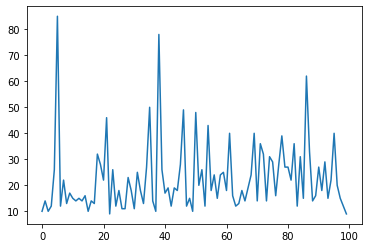

In [95]:
rand_scores = []
for i_episode in range(100):
    observation = env.reset()
    score = 0
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score += reward
        if done:
            break
    rand_scores.append(score)
env.close()
x_axis = [i for i in range(100)]
plt.plot(x_axis, rand_scores)
plt.show()

3)b)

In [0]:
n_actions = 2
input_dim = 4
# n_actions = 4
# input_dim = 8
GAMMA = 0.99
MINI_BATCH = 2
n_epsiodes = 2000
lr = 0.005

layer1_size = 16
layer2_size = 16
action_space = [x for x in range(n_actions)]

local_state = []
local_action = []
local_reward = []

batch_state = []
batch_action = []
batch_reward = []

flat_state = []
flat_action = []
flat_reward = []

In [0]:
def get_model():
  main_input = Input(shape=(input_dim,), name='main_input')
  aux_input = Input(shape=[1], name='aux_input')          # A(t)
  dense_1 = Dense(layer1_size, activation='relu')(main_input)
  dense_2 = Dense(layer2_size, activation='relu')(dense_1)
  main_output = Dense(n_actions, activation='softmax', name='main_output')(dense_2)
  # dense_3 = Dense(n_actions, activation=None)(dense_2)
  # main_output = Dense(n_actions, activation='softmax', name='main_output')(dense_3)

  def custom_loss_func(y_true, y_pred):
    pi = K.clip(y_pred, 1e-8, 1-1e-8)    # shape(2,) 
    # pi = K.minimum(y_pred, 1e-8)
    log_prob = y_true*K.log(pi)
    return -K.sum(log_prob*aux_input)

  model = Model(input=[main_input, aux_input], output=[main_output])
  model.compile(optimizer=Adam(lr=lr), loss=custom_loss_func)
  
  return model

In [0]:
def choose_action(observation):
  state = observation[np.newaxis, :]
  g = np.array([0])     # creating g, but its not used in calculation
  p = model.predict([state, g])[0]
  action = np.random.choice(action_space, p=p)
  return action

def flat_memory():
  flat_state = [item for sublist in batch_state for item in sublist]
  flat_action = [item for sublist in batch_action for item in sublist]
  flat_reward = [item for sublist in batch_reward for item in sublist]
  
def batch_memory():
  batch_state.append(local_state)
  batch_action.append(local_action)
  batch_reward.append(local_reward)

def local_memory(observation, action, reward):
  local_state.append(observation)
  local_action.append(action)
  local_reward.append(reward)

def clear_batch_memory():
  batch_state.clear()
  batch_action.clear()
  batch_reward.clear()

def clear_local_memory():
  local_state.clear()
  local_action.clear()
  local_reward.clear()

def learn(rtg=True, advantage=True):
  actions = np.zeros([len(flat_action), n_actions])
  for i in range(len(flat_action)):
    actions[i][flat_action[i]] = 1
  # actions[np.arange(len(action_memory)), action_memory] = 1

  G = np.zeros_like(batch_reward)
  
  if rtg:
    for k in range(MINI_BATCH):
      G[k][-1] = batch_reward[k][-1]
      for t in reversed(range(0, len(batch_reward[k])-1)):
        G[k][t] = GAMMA * G[k][t+1] + batch_reward[k][t]
  else:
    for k in range(MINI_BATCH):
      g = 0
      for t in reversed(range(0, len(batch_reward[k]))):
        g = GAMMA * g + batch_reward[k][t]
      for t in range(len(batch_reward[k])):
        G[k][t] = g


  if advantage and rtg:
    for k in range(MINI_BATCH):
      mean = np.mean(G[k])
      std = np.std(G[k])
      G[k] = (G[k]-mean)/std

  # flattening G 
  G = [item for sublist in G for item in sublist]

  # mean = np.mean(G)
  # std = np.std(G) if np.std(G) > 0 else 1
  # G = (G-mean)/std
  cost = model.train_on_batch([flat_state, G], actions)


In [0]:
def agent(rtg=True, advantage=True):
  global flat_state, flat_action, flat_reward
  score_history = []
  avg_scores = []
  env = gym.make('CartPole-v0')

  for epsiode in range(n_epsiodes):
    clear_batch_memory()
    score = 0
    for k in range(MINI_BATCH):
      # score = 0
      observation = env.reset()
      clear_local_memory()
      while True:
        action = choose_action(observation)
        observation_new, reward, done, _ = env.step(action)
        local_memory(observation,action, reward)
        observation = observation_new
        score += reward
        if done:
          batch_memory()
          break
      # score_history.append(score)
    flat_state = [item for sublist in batch_state for item in sublist]
    flat_action = [item for sublist in batch_action for item in sublist]
    flat_reward = [item for sublist in batch_reward for item in sublist]
    # flat_memory()
    learn(rtg, advantage)

    # testing after training
    
    observation = env.reset()
    while True:
      action = choose_action(observation)
      observation, reward, done, _ = env.step(action)
      score += reward
      if done:
        break
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    avg_scores.append(avg_score)
    print('epsiode: {}, score: {}, avg_score: {}'.format(epsiode, score, avg_score))
    if avg_score >= 550:
      break

  x_axis = [i for i in range(epsiode+1)]
  plt.plot(x_axis, avg_scores)
  plt.show()


reward-to-go: True

Advantage: True





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


epsiode: 0, score: 77.0, avg_score: 77.0
epsiode: 1, score: 47.0, avg_score: 62.0
epsiode: 2, score: 78.0, avg_score: 67.33333333333333
epsiode: 3, score: 57.0, avg_score: 64.75
epsiode: 4, score: 70.0, avg_score: 65.8
epsiode: 5, score: 40.0, avg_score: 61.5
epsiode: 6, score: 43.0, avg_score: 58.857142857142854
epsiode: 7, score: 77.0, avg_score: 61.125
epsiode: 8, score: 67.0, avg_score: 61.77777777777778
epsiode: 9, score: 77.0, avg_score: 63.3
epsiode: 10, score: 55.0, avg_score: 62.54545454545455
epsiode: 11, score: 68.0, avg_score: 63.0
epsiode: 12, score: 73.0, avg_score: 63.76923076923077
epsiode: 13, score: 135.0, avg_score: 68.85714285714286
epsiode: 14, score: 81.0, avg_score: 69.66666666666667
epsiode: 15, score: 106.0, avg_score: 71.9375
epsiode: 16, score: 64.0, avg_score: 71.47058823529412
epsiode: 17, score: 73.0, avg_score: 71.55555555555556
epsiode: 18, score: 115.0, avg_score: 73.84210526315789
epsiode: 19, score: 40.0, avg_score: 72.15
epsiode: 20, score: 85.0, avg

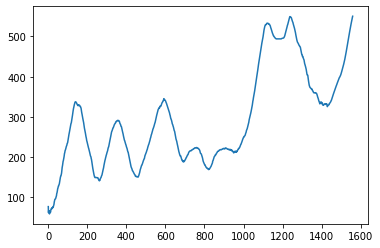

In [100]:
model = get_model()
agent(rtg=True, advantage=True)

reward-to-go: True

Advantage: False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


epsiode: 0, score: 65.0, avg_score: 65.0
epsiode: 1, score: 96.0, avg_score: 80.5
epsiode: 2, score: 56.0, avg_score: 72.33333333333333
epsiode: 3, score: 47.0, avg_score: 66.0
epsiode: 4, score: 66.0, avg_score: 66.0
epsiode: 5, score: 62.0, avg_score: 65.33333333333333
epsiode: 6, score: 73.0, avg_score: 66.42857142857143
epsiode: 7, score: 51.0, avg_score: 64.5
epsiode: 8, score: 103.0, avg_score: 68.77777777777777
epsiode: 9, score: 83.0, avg_score: 70.2
epsiode: 10, score: 146.0, avg_score: 77.0909090909091
epsiode: 11, score: 80.0, avg_score: 77.33333333333333
epsiode: 12, score: 42.0, avg_score: 74.61538461538461
epsiode: 13, score: 84.0, avg_score: 75.28571428571429
epsiode: 14, score: 183.0, avg_score: 82.46666666666667
epsiode: 15, score: 74.0, avg_score: 81.9375
epsiode: 16, score: 77.0, avg_score: 81.6470588235294
epsiode: 17, score: 106.0, avg_score: 83.0
epsiode: 18, score: 118.0, avg_score: 84.84210526315789
epsiode: 19, score: 90.0, avg_score: 85.1
epsiode: 20, score: 7

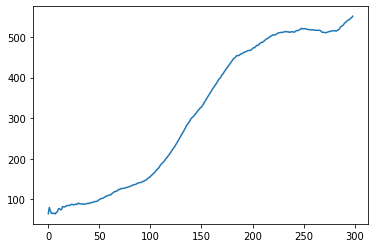

In [101]:
model = get_model()
agent(rtg=True, advantage=False)

reward-to-go: False

Advantage: True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


epsiode: 0, score: 66.0, avg_score: 66.0
epsiode: 1, score: 44.0, avg_score: 55.0
epsiode: 2, score: 69.0, avg_score: 59.666666666666664
epsiode: 3, score: 91.0, avg_score: 67.5
epsiode: 4, score: 47.0, avg_score: 63.4
epsiode: 5, score: 81.0, avg_score: 66.33333333333333
epsiode: 6, score: 70.0, avg_score: 66.85714285714286
epsiode: 7, score: 59.0, avg_score: 65.875
epsiode: 8, score: 74.0, avg_score: 66.77777777777777
epsiode: 9, score: 79.0, avg_score: 68.0
epsiode: 10, score: 88.0, avg_score: 69.81818181818181
epsiode: 11, score: 48.0, avg_score: 68.0
epsiode: 12, score: 63.0, avg_score: 67.61538461538461
epsiode: 13, score: 57.0, avg_score: 66.85714285714286
epsiode: 14, score: 85.0, avg_score: 68.06666666666666
epsiode: 15, score: 67.0, avg_score: 68.0
epsiode: 16, score: 92.0, avg_score: 69.41176470588235
epsiode: 17, score: 57.0, avg_score: 68.72222222222223
epsiode: 18, score: 67.0, avg_score: 68.63157894736842
epsiode: 19, score: 75.0, avg_score: 68.95
epsiode: 20, score: 126

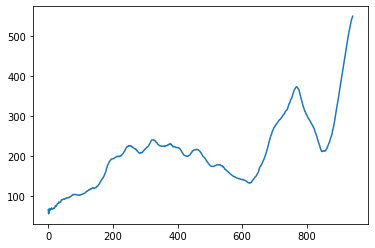

In [102]:
model = get_model()
agent(rtg=False, advantage=True)

reward-to-go: False

Advantage: False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


epsiode: 0, score: 122.0, avg_score: 122.0
epsiode: 1, score: 37.0, avg_score: 79.5
epsiode: 2, score: 94.0, avg_score: 84.33333333333333
epsiode: 3, score: 43.0, avg_score: 74.0
epsiode: 4, score: 92.0, avg_score: 77.6
epsiode: 5, score: 113.0, avg_score: 83.5
epsiode: 6, score: 111.0, avg_score: 87.42857142857143
epsiode: 7, score: 106.0, avg_score: 89.75
epsiode: 8, score: 57.0, avg_score: 86.11111111111111
epsiode: 9, score: 58.0, avg_score: 83.3
epsiode: 10, score: 71.0, avg_score: 82.18181818181819
epsiode: 11, score: 106.0, avg_score: 84.16666666666667
epsiode: 12, score: 65.0, avg_score: 82.6923076923077
epsiode: 13, score: 123.0, avg_score: 85.57142857142857
epsiode: 14, score: 131.0, avg_score: 88.6
epsiode: 15, score: 70.0, avg_score: 87.4375
epsiode: 16, score: 117.0, avg_score: 89.17647058823529
epsiode: 17, score: 85.0, avg_score: 88.94444444444444
epsiode: 18, score: 93.0, avg_score: 89.15789473684211
epsiode: 19, score: 79.0, avg_score: 88.65
epsiode: 20, score: 58.0, a

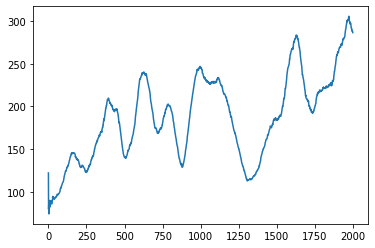

In [103]:
model = get_model()
agent(rtg=False, advantage=False)

3)c) Impact of batch size on policy gradient estimate

Batch size: 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


epsiode: 0, score: 66.0, avg_score: 66.0
epsiode: 1, score: 138.0, avg_score: 102.0
epsiode: 2, score: 78.0, avg_score: 94.0
epsiode: 3, score: 100.0, avg_score: 95.5
epsiode: 4, score: 69.0, avg_score: 90.2
epsiode: 5, score: 130.0, avg_score: 96.83333333333333
epsiode: 6, score: 75.0, avg_score: 93.71428571428571
epsiode: 7, score: 113.0, avg_score: 96.125
epsiode: 8, score: 108.0, avg_score: 97.44444444444444
epsiode: 9, score: 82.0, avg_score: 95.9
epsiode: 10, score: 125.0, avg_score: 98.54545454545455
epsiode: 11, score: 129.0, avg_score: 101.08333333333333
epsiode: 12, score: 86.0, avg_score: 99.92307692307692
epsiode: 13, score: 158.0, avg_score: 104.07142857142857
epsiode: 14, score: 86.0, avg_score: 102.86666666666666
epsiode: 15, score: 79.0, avg_score: 101.375
epsiode: 16, score: 97.0, avg_score: 101.11764705882354
epsiode: 17, score: 97.0, avg_score: 100.88888888888889
epsiode: 18, score: 70.0, avg_score: 99.26315789473684
epsiode: 19, score: 93.0, avg_score: 98.95
epsiode

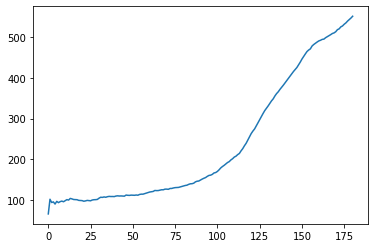

In [104]:
MINI_BATCH = 4
model = get_model()
agent(rtg=True, advantage=True)

Batch size: 16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


epsiode: 0, score: 341.0, avg_score: 341.0
epsiode: 1, score: 467.0, avg_score: 404.0
epsiode: 2, score: 427.0, avg_score: 411.6666666666667
epsiode: 3, score: 423.0, avg_score: 414.5
epsiode: 4, score: 501.0, avg_score: 431.8
epsiode: 5, score: 385.0, avg_score: 424.0
epsiode: 6, score: 376.0, avg_score: 417.14285714285717
epsiode: 7, score: 437.0, avg_score: 419.625
epsiode: 8, score: 443.0, avg_score: 422.22222222222223
epsiode: 9, score: 343.0, avg_score: 414.3
epsiode: 10, score: 344.0, avg_score: 407.90909090909093
epsiode: 11, score: 452.0, avg_score: 411.5833333333333
epsiode: 12, score: 475.0, avg_score: 416.46153846153845
epsiode: 13, score: 354.0, avg_score: 412.0
epsiode: 14, score: 353.0, avg_score: 408.06666666666666
epsiode: 15, score: 365.0, avg_score: 405.375
epsiode: 16, score: 410.0, avg_score: 405.6470588235294
epsiode: 17, score: 367.0, avg_score: 403.5
epsiode: 18, score: 373.0, avg_score: 401.89473684210526
epsiode: 19, score: 376.0, avg_score: 400.6
epsiode: 20,

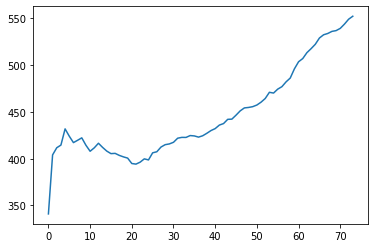

In [105]:
MINI_BATCH = 16
model = get_model()
agent(rtg=True, advantage=True)